# Navigation

1. Delete all unnecessary columns

2. Delete all entries with a neutral rating (overall = 3)

3. Binary Class "good" for "Positive" and "Negative" sentiment

4. Resample to obtain balanced dataset

5. Data Merging for Genre Attributes (dummy variables)

6. Add Personality & Grammar Features

7. Normalizing numerical features

8. Create interaction terms between movie genre and personality

9. Show descriptive statistics for variables

10. Use all features for a prediction model (Ridge Classifier, Neural Net)

In [9]:
import pandas as pd
import os as os
import json as js
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pickle

#importing libraries for NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

#Text Classification Material
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MAHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.chdir("C:/Users/MAHAM/Desktop/Studium/Capstone Project/master__thesis")
os.getcwd()

'C:\\Users\\MAHAM\\Desktop\\Studium\\Capstone Project\\master__thesis'

# Data Preparation
### Merging Genre Data with Review Data

#### Review Data

In [16]:
with open ('movies_data', 'rb') as fr:
    full_df = pickle.load(fr)

In [25]:
full_df.shape

(1697533, 9)

#### Genre Labels Data

In [17]:
dfg = pd.DataFrame.from_csv("labels.csv",index_col=None)

C:\Users\Pegah\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [18]:
dfg = pd.DataFrame(dfg)

In [19]:
dfg.head()

,ASIN,Categories
0,B0029Z8KCY,"['Movies & TV', 'Boxed Sets', 'Anime']"
1,B00004CQT3,"['Movies & TV', 'Genre for Featured Categories..."
2,B00004CQT4,"['Movies & TV', 'Genre for Featured Categories..."
3,B006JIUN2W,[]
4,B004MPGBHK,[]


In [20]:
dfg.shape

(253059, 2)

##### Deleting all rows where "Categories" is empty

In [21]:
dfg = dfg[dfg["Categories"].map(len)!=2]

In [22]:
dfg.shape

(217740, 2)

##### Keeping all Movies with the following ten Genres
- Comedy
- Art house and international
- Documentary
- Drama
- Action & Adventure
- Horror
- Science Fiction
- Animation
- Kids & Family
- Musicals

In [23]:
dfg=dfg[dfg['Categories'].str.contains("Comedy|Art House and International|Documentary|Drama|Action & Adventure|Horror|Science Fiction|Animation|Kids & Family|Musicals")]

In [27]:
dfg.head()

,ASIN,Categories
1,B00004CQT3,"['Movies & TV', 'Genre for Featured Categories..."
2,B00004CQT4,"['Movies & TV', 'Genre for Featured Categories..."
8,B000NDFLWG,"['Movies & TV', 'Independently Distributed', '..."
10,B008FPU7AA,"['Movies & TV', 'Genre for Featured Categories..."
11,0790747324,"['Movies & TV', 'Science Fiction & Fantasy', '..."


### Balancing the Genres by Undersampling

In [49]:
genres=["Comedy","Art House & International","Documentary","Drama","Action & Adventure","Horror","Science Fiction","Animation","Kids & Family","Musicals"]
for genre in genres:
    count=len(dfg[dfg['Categories'].str.contains(genre)])
    print(genre,str(count))

Comedy 17304
Art House & International 1436
Documentary 14186
Drama 21229
Action & Adventure 20057
Horror 5562
Science Fiction 12565
Animation 6949
Kids & Family 10890
Musicals 8243


##### As we can see, the rarest category here is Art House & International

In [44]:
smallest_count=len(dfg[dfg['Categories'].str.contains("Art House & International")])
smallest_count

1436

In [50]:
genres_wo_art = ["Comedy","Documentary","Drama","Action & Adventure","Horror","Science Fiction","Animation","Kids & Family","Musicals"]


In [51]:
# Divide by class
dfg_art = dfg[dfg['Categories'].str.contains("Art House & International")]
n=0
for genre in genres_wo_art:
    df_class_pos = dfg[dfg['Categories'].str.contains(genre)]
    df_class_pos_under = df_class_pos.sample(smallest_count, random_state=123)
    if n==0:
        df2= pd.concat([df_class_pos_under, dfg_art], axis=0)
    else:
        df2= pd.concat([df_class_pos_under, df2], axis=0)
    n+=1

#### Approximately equally large groups

In [52]:
for genre in genres:
    count=len(df2[df2['Categories'].str.contains(genre)])
    print(genre,str(count))

Comedy 1951
Art House & International 1534
Documentary 1463
Drama 2059
Action & Adventure 1697
Horror 1436
Science Fiction 2794
Animation 2183
Kids & Family 1436
Musicals 1497


In [54]:
df2.head(3)

,ASIN,Categories
131967,B004V2S4TC,"['Movies & TV', 'Musicals & Performing Arts', ..."
242178,B002JP9HIU,"['Movies & TV', 'Musicals & Performing Arts', ..."
158056,6302985935,"['Movies & TV', 'Studio Specials', '20th Centu..."


In [55]:
df2.shape

(14360, 2)

##### Create list of 14360 selected movies 

In [62]:
selected_movies=df2["ASIN"].values
len(selected_movies)

14360

##### Reduces the number of entries from 1.7 million to around 78,000 

In [60]:
full_df.shape

(1697533, 9)

In [63]:
df=full_df[full_df["asin"].isin(selected_movies)]
df.shape

(78423, 9)

#### Delete unused columns

In [64]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1812,AOA7DLVR783CM,0738920339,2 princesses mom,"[0, 0]",This one really makes ya want to get up and mo...,5.0,Awesome!,1109808000,"03 3, 2005"


In [65]:
drop_columns=["reviewerName","helpful","summary","unixReviewTime","reviewTime"]
df = df.drop(columns=drop_columns)
df.head(1)

,reviewerID,asin,reviewText,overall
1812,AOA7DLVR783CM,0738920339,This one really makes ya want to get up and mo...,5.0


#### Balanced Dataset

##### Delete neutral reviews

In [66]:
df.shape

(78423, 4)

In [67]:
df = df[df.overall != 3]

In [68]:
df.shape

(68953, 4)

In [69]:
df = df.reset_index()
df = df.drop(columns="index")
df.shape

(68953, 4)

##### Create Binary Target Variable

In [70]:
df["good"]=[1 if df.loc[i,"overall"]>=4 else 0 for i in range(len(df))]

##### Resample using **Undersampling**

In [71]:
# without resampling 87% of the reviews are positive
df.good.mean()

0.8636027438980175

In [72]:
# Class count
count_pos, count_neg = df.good.value_counts()
count_pos,count_neg

(59548, 9405)

In [73]:
# Divide by class
df_class_pos = df[df['good'] == 1]
df_class_neg = df[df['good'] == 0]

df_class_pos_under = df_class_pos.sample(count_neg, random_state=123)
df= pd.concat([df_class_pos_under, df_class_neg], axis=0)

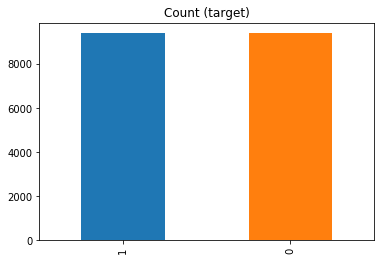

In [74]:
# Balanced data set
df.good.value_counts().plot(kind='bar', title='Count (target)');

In [76]:
df.good.mean(), df.shape

(0.5, (18810, 5))

## Add Genre features to selected movies

In [80]:
dfg=dfg.set_index("ASIN")
df = df.reset_index()
df = df.drop(columns="index")

In [81]:
len(genres), genres

(10,
 ['Comedy',
  'Art House & International',
  'Documentary',
  'Drama',
  'Action & Adventure',
  'Horror',
  'Science Fiction',
  'Animation',
  'Kids & Family',
  'Musicals'])

##### Produce ten dummy variables for each genre

In [82]:
for genre in genres:
    df[genre]=0
    for row in range(len(df)):
        movie_id = df.loc[row,"asin"]
        if genre in dfg.loc[movie_id,"Categories"]:
            df.loc[row,genre]=1

In [84]:
df.head()

,reviewerID,asin,reviewText,overall,good,Comedy,Art House & International,Documentary,Drama,Action & Adventure,Horror,Science Fiction,Animation,Kids & Family,Musicals
0,A19JYLHD94K94D,6304239327,Jan Svankajer's feature film follow up to his ...,5.0,1,0,1,0,1,0,0,0,0,0,0
1,A144W50UYZG4YX,630339406X,Big-1988100mins/ColourTom HanksElizabeth Perki...,4.0,1,0,0,0,0,0,0,0,0,1,0
2,A16QODENBJVUI1,B0007PALGG,Of all the films coming out this holiday movie...,4.0,1,0,0,0,1,0,0,0,0,0,0
3,A3L2856DIMUXJY,B0001DCR0C,"As noted by a number of reviewers, this starte...",4.0,1,0,1,0,1,0,0,0,0,0,0
4,A1Z54EM24Y40LL,B00004WI5C,This is really a cute video. It's pretty long...,4.0,1,0,0,0,0,0,0,0,0,0,1


### Genre Descriptions

In [95]:
for genre in genres:
    count=df[genre].mean()
    print(genre,str(count))

Comedy 0.15135566188197766
Art House & International 0.20914407230196705
Documentary 0.02227538543328017
Drama 0.18771929824561404
Action & Adventure 0.14019138755980862
Horror 0.14545454545454545
Science Fiction 0.25656565656565655
Animation 0.16767676767676767
Kids & Family 0.03487506645401382
Musicals 0.06156299840510367


In [96]:
col_drop = ["Documentary","Musicals", "Kids & Family"]
df = df.drop(columns=col_drop)

In [99]:
df.columns, df.good.mean()

(Index(['reviewerID', 'asin', 'reviewText', 'overall', 'good', 'Comedy',
        'Art House & International', 'Drama', 'Action & Adventure', 'Horror',
        'Science Fiction', 'Animation'],
       dtype='object'), 0.5)

### Add features
#### Grammar

In [100]:
def feature_creator(feature, df):
    df[feature] = [df.loc[i, "reviewText"].count(feature)/((len(df.loc[i, "reviewText"]))+0.0001) for i in range(len(df))]

In [101]:
dataframes=[df]
punc_marks = ("!","?",",","."," ")
for df in dataframes:
    # ADD FEATURE 1: Length of comment
    df["length"] = [len(df.loc[i, "reviewText"]) for i in range(len(df))]
    for f in punc_marks:
        # ADD FEATURE 2,3,4: Punctuation marks, and average word length (represented by whitespace/length)
        feature_creator(f, df)

In [5]:
df.columns

Index(['reviewerID', 'asin', 'reviewText', 'overall', 'good', 'Comedy',
       'Art House & International', 'Drama', 'Action & Adventure', 'Horror',
       'Science Fiction', 'Animation', 'length', '!', '?', ',', '.', ' ',
       'Extro', 'Agree', 'Neuro', 'Open', 'Consc', 'Extro_Comedy',
       'Extro_Art House & International', 'Extro_Drama',
       'Extro_Action & Adventure', 'Extro_Horror', 'Extro_Science Fiction',
       'Extro_Animation', 'Agree_Comedy', 'Agree_Art House & International',
       'Agree_Drama', 'Agree_Action & Adventure', 'Agree_Horror',
       'Agree_Science Fiction', 'Agree_Animation', 'Neuro_Comedy',
       'Neuro_Art House & International', 'Neuro_Drama',
       'Neuro_Action & Adventure', 'Neuro_Horror', 'Neuro_Science Fiction',
       'Neuro_Animation', 'Open_Comedy', 'Open_Art House & International',
       'Open_Drama', 'Open_Action & Adventure', 'Open_Horror',
       'Open_Science Fiction', 'Open_Animation', 'Consc_Comedy',
       'Consc_Art House & Inter

In [13]:
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MAHAM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [14]:
# Add feature of Relative amount of word types
word_types=["noun", "adj", "verb (simple)","verb (simple past)", "verb (past participle)", "verb (gerund)", "adverb", "preposition"]
word_types_abb=["NN", "JJ","VB","VBD", "VBN", "VBG", "RB", "IN"]
word_types_dictionary={"noun":"NN", "adj":"JJ", "verb (simple)":"VB","verb (simple past)":"VBD", "verb (past participle)":"VBN", "verb (gerund)":"VBG", "adverb":"RB", "preposition":"IN"}
for wt in word_types:
    df[wt]=df["good"]
for i in range(len(df)):
    text = df.loc[i, "reviewText"]
    tokens = nltk.word_tokenize(text.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    count_dic = dict((word, float(count)/total) for word,count in counts.items())
    for wt, abb in word_types_dictionary.items():
        if abb in count_dic:
            df.iloc[i, df.columns.get_loc(wt)] = count_dic[abb]
        else:
            df.iloc[i, df.columns.get_loc(wt)] = 0 

In [16]:
# normalizing the values
for col in word_types:
    df[col]=(df[col]-df[col].mean())/df[col].std()

#### Personality

In [102]:
# Create column with text without puctuation for personality
df["text_plain"] = df['reviewText'].map(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [103]:
import csv
letters = ["E", "A", "N", "O", "C"]
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
for df in dataframes:
    for column in big5:
        df[column]=df["overall"]
    for j,letter in enumerate(letters):
        reader = csv.reader(open('%s.top100.1to3grams.gender_age_controlled.rmatrix.csv'%(letter), 'r'))
        dic = {}
        for row in reader:
            k, v, z= row
            dic[k] = v
        dic.pop("")
        for i in range(len(df)):
            text = df.iloc[i, df.columns.get_loc("text_plain")]
            tokens = nltk.word_tokenize(text.lower())
            text = nltk.Text(tokens)
            word_value = 0
            for word, value in dic.items():
                counter = text.count(word)
                word_value = word_value+(counter*float(value))
            #current_length = len(df.columns)
            personality_number = word_value/((df.iloc[i,df.columns.get_loc("length")])+0.0001)
            df.iloc[i, df.columns.get_loc(big5[j])] = personality_number

In [104]:
df = df.drop(columns="text_plain")

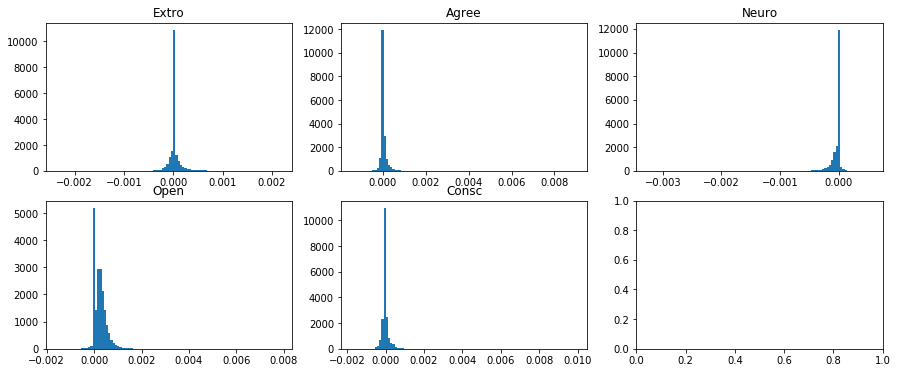

In [105]:
fig, axs = plt.subplots(2,3, figsize=(15,6))
for i in range(3):
    axs[0,i].hist(df[big5[i]], bins=100)
    axs[0,i].set_title(big5[i])
for i in range(3,5):
    axs[1,i-3].hist(df[big5[i]], bins=100)
    axs[1,i-3].set_title(big5[i])

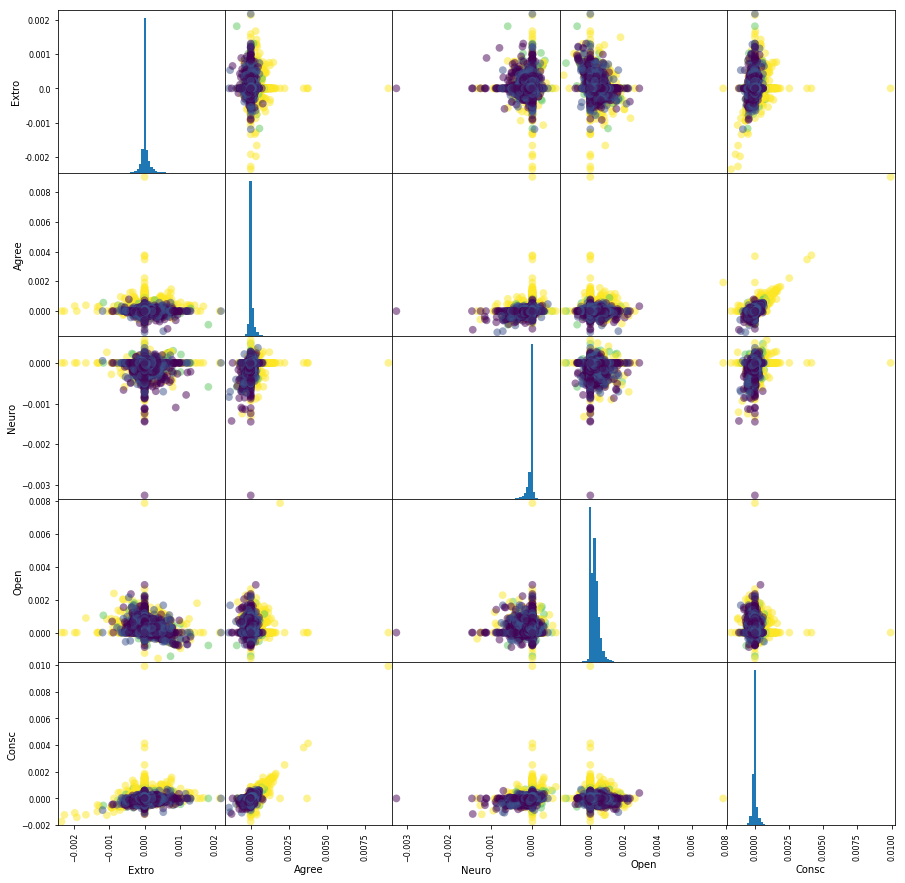

In [106]:
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
het=pd.plotting.scatter_matrix(df[big5], c=df["overall"], figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 70}, s=60, alpha=.5)

In [107]:
df.columns

Index(['reviewerID', 'asin', 'reviewText', 'overall', 'good', 'Comedy',
       'Art House & International', 'Drama', 'Action & Adventure', 'Horror',
       'Science Fiction', 'Animation', 'length', '!', '?', ',', '.', ' ',
       'Extro', 'Agree', 'Neuro', 'Open', 'Consc'],
      dtype='object')

In [108]:
# Check how many users review more than once in this dataset
df.shape[0], len(set(df.reviewerID)),len(set(df.asin))

(18810, 13448, 2447)

### Normalization

In [109]:
# word types were already normalized above
numeric = ['Extro', 'Agree', 'Neuro', 'Open', 'Consc', 'length', '!', '?', ',','.', ' ']

In [110]:
for col in numeric:
    df[col]=(df[col]-df[col].mean())/df[col].std()

## Interaction terms

In [111]:
big5 = ["Extro", "Agree", "Neuro", "Open", "Consc"]
genres=["Comedy","Art House & International","Drama","Action & Adventure","Horror","Science Fiction","Animation"]
def create_interaction_terms(df):
    for personality in big5:
        for genre in genres:
            df[personality+"_"+genre]=df.apply(lambda x: x[personality]*x[genre], axis=1)

In [112]:
create_interaction_terms(df)

In [113]:
df.shape

(18810, 58)

In [114]:
with open ('data_25_07', 'wb') as fw:
    pickle.dump(df, fw)

### Pre-Trained Sentiment Analyser

In [18]:
df.columns

Index(['reviewerID', 'asin', 'reviewText', 'overall', 'good', 'Comedy',
       'Art House & International', 'Drama', 'Action & Adventure', 'Horror',
       'Science Fiction', 'Animation', 'length', '!', '?', ',', '.', ' ',
       'Extro', 'Agree', 'Neuro', 'Open', 'Consc', 'Extro_Comedy',
       'Extro_Art House & International', 'Extro_Drama',
       'Extro_Action & Adventure', 'Extro_Horror', 'Extro_Science Fiction',
       'Extro_Animation', 'Agree_Comedy', 'Agree_Art House & International',
       'Agree_Drama', 'Agree_Action & Adventure', 'Agree_Horror',
       'Agree_Science Fiction', 'Agree_Animation', 'Neuro_Comedy',
       'Neuro_Art House & International', 'Neuro_Drama',
       'Neuro_Action & Adventure', 'Neuro_Horror', 'Neuro_Science Fiction',
       'Neuro_Animation', 'Open_Comedy', 'Open_Art House & International',
       'Open_Drama', 'Open_Action & Adventure', 'Open_Horror',
       'Open_Science Fiction', 'Open_Animation', 'Consc_Comedy',
       'Consc_Art House & Inter

In [21]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [22]:
df["sentiment"]=df["reviewText"].map(lambda x :analyser.polarity_scores(x)["compound"])

In [23]:
df.head(2)

,reviewerID,asin,reviewText,overall,good,Comedy,Art House & International,Drama,Action & Adventure,Horror,...,corpus,noun,adj,verb (simple),verb (simple past),verb (past participle),verb (gerund),adverb,preposition,sentiment
0,A19JYLHD94K94D,6304239327,Jan Svankajer's feature film follow up to his ...,5.0,1,0,1,1,0,0,...,jan svankaj featur film follow masterpiec alic...,0.589624,0.801433,-1.084828,-0.866063,-1.115746,0.020607,0.578095,0.141700,0.9904
1,A144W50UYZG4YX,630339406X,Big-1988100mins/ColourTom HanksElizabeth Perki...,4.0,1,0,0,0,0,0,...,big min colourtom hankselizabeth perkinsrobert...,0.923381,1.265269,-1.372903,-0.648728,0.800474,0.674204,-0.962428,0.004977,0.9934


In [24]:
with open ('df_07_08', 'wb') as fw:
    pickle.dump(df, fw)

### END of Data Pre-Processing

# Analysis

In [3]:
with open ('data_26_07_w_corpus', 'rb') as fr:
    df = pickle.load(fr)

In [23]:
df.columns[5:57]

Index(['Comedy', 'Art House & International', 'Drama', 'Action & Adventure',
       'Horror', 'Science Fiction', 'Animation', 'length', '!', '?', ',', '.',
       ' ', 'Extro', 'Agree', 'Neuro', 'Open', 'Consc', 'Extro_Comedy',
       'Extro_Art House & International', 'Extro_Drama',
       'Extro_Action & Adventure', 'Extro_Horror', 'Extro_Science Fiction',
       'Extro_Animation', 'Agree_Comedy', 'Agree_Art House & International',
       'Agree_Drama', 'Agree_Action & Adventure', 'Agree_Horror',
       'Agree_Science Fiction', 'Agree_Animation', 'Neuro_Comedy',
       'Neuro_Art House & International', 'Neuro_Drama',
       'Neuro_Action & Adventure', 'Neuro_Horror', 'Neuro_Science Fiction',
       'Neuro_Animation', 'Open_Comedy', 'Open_Art House & International',
       'Open_Drama', 'Open_Action & Adventure', 'Open_Horror',
       'Open_Science Fiction', 'Open_Animation', 'Consc_Comedy',
       'Consc_Art House & International', 'Consc_Drama',
       'Consc_Action & Adventure', '

## Linear Regression

In [24]:
from sklearn import  linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = df.drop(columns="Animation")
X1 = X.iloc[:,5:57]
y = df["good"]

X2 = sm.add_constant(X1)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


#grammar and personality model:
#0.087 adj r^2
#-12794
# 2.561e+04 aic
# 2.570e+04 bic

#grammar personality and genre:
#0.109 adj r^2
#-12559
# 2.515e+04 aic
# 2.530e+04 bic

#full model with interactions 
#5 bis 57:
#0.115 adj r^2
#-12473
# AIC:  2.505e+04
# BIC:  2.547e+04

                            OLS Regression Results                            
Dep. Variable:                   good   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     48.16
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:26:07   Log-Likelihood:                -12473.
No. Observations:               18810   AIC:                         2.505e+04
Df Residuals:                   18757   BIC:                         2.547e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [9]:
df.columns[5:12]

Index(['Comedy', 'Art House & International', 'Drama', 'Action & Adventure',
       'Horror', 'Science Fiction', 'Animation'],
      dtype='object')

In [11]:
df.good.mean()

0.5

In [14]:
X = df.iloc[:,5:12]
y = df["good"]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   good   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     132.2
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          9.44e-191
Time:                        10:44:41   Log-Likelihood:                -13200.
No. Observations:               18810   AIC:                         2.642e+04
Df Residuals:                   18802   BIC:                         2.648e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Ridge Classifier

In [7]:
X = df.iloc[:,5:]
y = df["good"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [8]:
from sklearn.linear_model import RidgeClassifierCV

clf = RidgeClassifierCV(alphas=[1e-7,1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

In [9]:
clf.score(X_test, y_test) 

0.6445248273594213

In [10]:
clf.alpha_

1.0

In [15]:
d= {"Variable" : list(df.columns[5:]),"Coefficients":list(clf.coef_[0])}
results=pd.DataFrame(data=d)
results[1:]

,Variable,Coefficients
1,Documentary,0.433291
2,Drama,0.111877
3,Action & Adventure,0.120066
4,Horror,0.104129
5,Science Fiction,0.094080
6,Animation,0.368246
7,Kids & Family,0.370055
8,Musicals,0.619277
9,length,-0.023975
10,!,0.030370


In [12]:
log = LogisticRegression(solver='liblinear')#regularization is applied by default
log.fit(X_train, y_train)
accuracy=log.score(X_test,y_test)

In [13]:
accuracy

0.657185136468267

# Neural Nets

In [165]:
from sklearn.neural_network import MLPClassifier

In [195]:
X = df.iloc[:,5:]
y = df["good"]
mlp = MLPClassifier(alpha=0.9,random_state=123)
mlp.fit(X_train, y_train)
score = mlp.score(X_test, y_test)
score

0.6762578099309438

# Comparison with other methods

## VADER

In [182]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [183]:
df["sentiment"]=df["reviewText"].map(lambda x :analyser.polarity_scores(x)["compound"])

In [184]:
df["sentiment_binary"]=df["sentiment"]>0

In [187]:
pd.crosstab(df["sentiment_binary"],df["good"])

good,0,1
sentiment_binary,,
False,5820,1460
True,6344,10704


In [188]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df["sentiment_binary"],df["good"])

array([[ 5820,  1460],
       [ 6344, 10704]], dtype=int64)

In [189]:
from sklearn.metrics import accuracy_score
accuracy_score(df["sentiment_binary"],df["good"])

0.679217362709635

In [ ]:
het=pd.plotting.scatter_matrix(df[big5], c=df["overall"], figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 70}, s=60, alpha=.5)


### Creating User-Relative features 

In [44]:
df_m_index=df_m.reset_index()
df_h_index=df_h.reset_index()
df_a_index=df_a.reset_index()

In [8]:
users_mean_df_m=df_m.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_m.shape

(1000, 25)

In [9]:
users_mean_df_h=df_h.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_a=df_a.groupby(["reviewerID"],as_index=False).mean()
users_mean_df_h.shape,users_mean_df_a.shape

((1000, 25), (1000, 25))

In [49]:
columns = big5
for column in columns:
        df_m_index[column+"_dm"]=df_m_index["good"]
        for user in unique_reviewer_IDs_m:
            indices = df_m_index.index[df_m_index['reviewerID'] == user].tolist()
            for index in indices:
                df_m_index.iloc[[index],df_m_index.columns.get_loc(column+"_dm")]=df_m_index.iloc[[index],df_m_index.columns.get_loc(column)]-(list(users_mean_df_m[users_mean_df_m["reviewerID"] == user][column])[0])

In [51]:
for column in columns:
    df_h_index[column+"_dm"]=df_m_index["good"]
    for user in unique_reviewer_IDs_h:
        indices = df_h_index.index[df_h_index['reviewerID'] == user].tolist()
        for index in indices:
            df_h_index.iloc[[index],df_h_index.columns.get_loc(column+"_dm")]=df_h_index.iloc[[index],df_h_index.columns.get_loc(column)]-(list(users_mean_df_h[users_mean_df_h["reviewerID"] == user][column])[0])
                
for column in columns:
    df_a_index[column+"_dm"]=df_m_index["good"]
    for user in unique_reviewer_IDs_a:
        indices = df_a_index.index[df_a_index['reviewerID'] == user].tolist()
        for index in indices:
            df_a_index.iloc[[index],df_a_index.columns.get_loc(column+"_dm")]=df_a_index.iloc[[index],df_a_index.columns.get_loc(column)]-(list(users_mean_df_a[users_mean_df_a["reviewerID"] == user][column])[0])

In [16]:
# Creating relative frequencies regarding each person
# by Substraction through personal mean
word_types=["noun", "adj", "verb (simple)","verb (simple past)", "verb (past participle)", "verb (gerund)", "adverb", "preposition"]
punc_marks = ["!","?",",","."," "]
columns= word_types+punc_marks
columns= columns+["length"]
df_index = [df_m_index,df_h_index,df_a_index]
df_mean = [users_mean_df_m, users_mean_df_h, users_mean_df_a]
unique_reviewer_IDs = [unique_reviewer_IDs_m,unique_reviewer_IDs_h,unique_reviewer_IDs_a]

In [17]:
for i in range(3):
    for column in columns:
        df_index[i][column+"_rel_sub"]=df_index[i]["good"]
        for user in unique_reviewer_IDs[i]:
            indices = df_index[i].index[df_index[i]['reviewerID'] == user].tolist()
            for index in indices:
                df_index[i].iloc[[index],df_index[i].columns.get_loc(column+"_rel_sub")]=df_index[i].iloc[[index],df_index[i].columns.get_loc(column)]-(list(df_mean[i][df_mean[i]["reviewerID"] == user][column])[0])

# Comparison with Bag-of-Words

In [3]:
with open ('genre_personality_24_07_P', 'rb') as fr:
    df = pickle.load(fr)

In [4]:
df.head(2)

,reviewerID,asin,reviewText,overall,good,Comedy,Documentary,Drama,Action & Adventure,Horror,...,Open_Musicals,Consc_Comedy,Consc_Documentary,Consc_Drama,Consc_Action & Adventure,Consc_Horror,Consc_Science Fiction,Consc_Animation,Consc_Kids & Family,Consc_Musicals
0,A3FMXA3WZ5STN7,6304117752,This movie is classical and wonderful. It's fu...,5.0,1,0,0,0,0,0,...,0.65407,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.427246
1,AULWICH7QPKOJ,6304288433,The transfer on this is pretty good. I believ...,4.0,1,0,0,0,0,1,...,0.00000,-0.0,-0.0,-0.0,-0.0,-0.008881,-0.0,-0.0,-0.0,-0.000000


In [20]:
df["corpus"] = df['reviewText'].map(lambda x: re.sub('[^a-zA-Z]', ' ', x))
#Making everything lowercase
df["corpus"] = df["corpus"].map(lambda x: x.lower())
#splitting the sentence into words
df["corpus"] = df["corpus"].map(lambda x: x.split())
ps = PorterStemmer()
# delete stop words and stemming the remaining words
df["corpus"] = df["corpus"].map(lambda x:[ps.stem(word) for word in x if not word in set(stopwords.words('english'))])
df["corpus"] = df["corpus"].map(lambda x: ' '.join(x))

In [ ]:
#with open ('data_26_07_w_corpus', 'wb') as fw:
#    pickle.dump(df, fw)

In [8]:
with open ('data_26_07_w_corpus', 'rb') as fr:
    df = pickle.load(fr)

In [9]:
median_O = df.loc[:,"Open"].median()
median_N = df.loc[:,"Neuro"].median()
median_A = df.loc[:,"Agree"].median()

# dataframe with high openness
df_H_O = df[df.Open >= median_O]
# df with low openness
df_L_O = df[df.Open < median_O]
# dataframe with high openness
df_H_N = df[df.Neuro >= median_N]
# df with low openness
df_L_N = df[df.Neuro < median_N]

# dataframe with high Agreeableness
df_H_A = df[df.Agree >= median_A]
# df with low Agreeableness
df_L_A = df[df.Agree < median_A]

In [19]:
median_A, median_N, median_O

(-0.21503994493254414, 0.3723573823917685, -0.13265988405009393)

In [10]:
import math
# df with random split
# reshuffle first
df = df.sample(frac=1).reset_index(drop=True)
half = math.ceil(len(df)/2)
df1 = df.iloc[:half,:]
df2 = df.iloc[half:,]

In [17]:
dataframes = [df1,df2,df_H_O,df_L_O,df_H_N,df_L_N,df_H_A,df_L_A]
dataframes_names = ["df1","df2","df_H_O","df_L_O","df_H_N","df_L_N","df_H_A","df_L_A"]
for dfx, name in zip(dataframes,dataframes_names):
    print (name, dfx.shape)

df1 (9405, 59)
df2 (9405, 59)
df_H_O (9405, 59)
df_L_O (9405, 59)
df_H_N (12248, 59)
df_L_N (6562, 59)
df_H_A (14964, 59)
df_L_A (3846, 59)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# RELEVANT PART

In [15]:
# df1 and df2 are random splits and df_H_O means High Openness, 
# df_L_O means low opennes etc, I split my median
dataframes = [df1,df2,df_H_O,df_L_O,df_H_N,df_L_N,df_H_A,df_L_A]
dataframes_names = ["df1","df2","df_H_O","df_L_O","df_H_N","df_L_N","df_H_A","df_L_A"]

In [20]:
for dfx, name in zip(dataframes,dataframes_names):
    cv = CountVectorizer(max_features = 500, ngram_range=(1,2))
    XX = cv.fit_transform(dfx["corpus"]).toarray()
    # using relative word counts instead of absolute ones
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(XX).toarray()
    X = tfidf
    y=dfx["good"]
    acc=[]
    for seed in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)
        log = LogisticRegression(solver='liblinear')#regularization is applied by default
        log.fit(X_train, y_train)
        accuracy=log.score(X_test,y_test)
        acc.append(accuracy)
    print(name," ",sum(acc)/len(acc), len(dfx))

df1   0.8127692743764169 9405
df2   0.8189058956916099 9405
df_H_O   0.813421201814059 9405
df_L_O   0.818792517006803 9405
df_H_N   0.8175919878075331 12248
df_L_N   0.8214503351614868 6562
df_H_A   0.8185957408892452 14964
df_L_A   0.7974012474012474 3846


# END

In [14]:
from sklearn.linear_model import RidgeClassifierCV
#X = df.iloc[:,5:]
#y = df["good"]
clf = RidgeClassifierCV(alphas=[1e-7,1e-6,1e-5,1e-4,1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
clf.score(X_test, y_test) 

0.8313054916146004

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
#X = df.iloc[:,5:]
#y = df["good"]
mlp = MLPClassifier(alpha=0.9,random_state=123)
mlp.fit(X_train, y_train)
score = mlp.score(X_test, y_test)
score

0.8313054916146004